# Linear Regression: Training, Testing, and Predicting

# 1. General Setup

In [1]:
# Import analytics libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import machine learning dependencies
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [2]:
# Raise errors, instead of give warnings
pd.set_option('mode.chained_Assignment', 'raise')

In [3]:
# Import data
import os
data_file_path = os.path.join('Data','stocks.csv')

# Preview data
stocks = pd.read_csv(data_file_path, index_col='Date')
display(stocks.head())
display(stocks.tail())

,Adj. Close,Open-Close Percent Change,High-Low Percent Change,Adj. Volume,Forecast
Date,,,,,
2004-08-19,50.322842,0.324968,8.441017,44659000.0,109.713676
2004-08-20,54.322689,7.227007,8.537313,22834300.0,110.230270
2004-08-23,54.869377,-1.227880,4.062357,18256100.0,110.064759
2004-08-24,52.597363,-5.726357,7.753210,15247300.0,110.340611
2004-08-25,53.164113,1.183658,3.966115,9188600.0,111.489156


,Adj. Close,Open-Close Percent Change,High-Low Percent Change,Adj. Volume,Forecast
Date,,,,,
2018-03-21,1094.00,0.130884,1.976619,1990515.0,NaN
2018-03-22,1053.15,-2.487014,3.265882,3418154.0,NaN
2018-03-23,1026.55,-2.360729,4.089299,2413517.0,NaN
2018-03-26,1054.09,0.332191,4.818025,3272409.0,NaN
2018-03-27,1006.94,-5.353887,6.707965,2940957.0,NaN


# 2. Preprocessing

In [4]:
# define features and labels
X = np.array(stocks.drop(['Forecast'], 1))
y = np.array(stocks['Forecast'])

print(X)
print(y)

[[ 5.03228418e+01  3.24967503e-01  8.44101709e+00  4.46590000e+07]
 [ 5.43226889e+01  7.22700723e+00  8.53731343e+00  2.28343000e+07]
 [ 5.48693765e+01 -1.22788010e+00  4.06235672e+00  1.82561000e+07]
 ...
 [ 1.02655000e+03 -2.36072933e+00  4.08929913e+00  2.41351700e+06]
 [ 1.05409000e+03  3.32191129e-01  4.81802529e+00  3.27240900e+06]
 [ 1.00694000e+03 -5.35388664e+00  6.70796496e+00  2.94095700e+06]]
[109.71367561 110.23027028 110.06475937 ...          nan          nan
          nan]


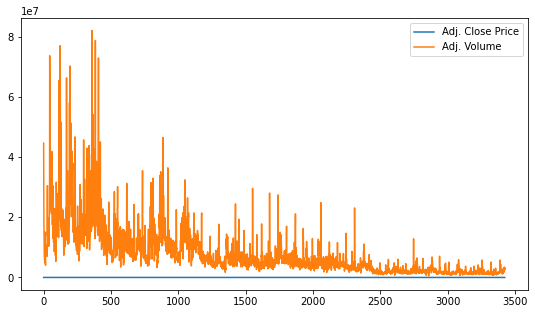

In [5]:
# Preview pre-scaled data
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(X[:,0], label='Adj. Close Price')
plt.plot(X[:,3], label = 'Adj. Volume')
plt.legend()

In [6]:
# Create copies of original data
X_original = X.copy(order='C')
y_original = y.copy(order='C')

# Initialize scaler
scaler = StandardScaler()

# Fit data
scaler.fit(X, y)

# Scale features
X = scaler.transform(X)

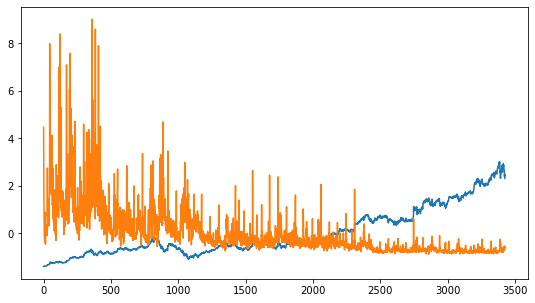

In [7]:
# Preview scaled data
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(X[:,0], label='Adj. Close Price')
plt.plot(X[:,3], label='Adj. volume')

# 3. Address Missing Values

Recall that to make our forecast column, we shifted each adjusted close price up $x$ rows, where $x$ was 5% of the length of the dataframe, which in this case is 172 rows.  Consequently, the last 172 rows of the forecast column are null, as there were no values to shift into these rows.

In [8]:
# Define the number of days out we want to forecast out
# In this case, want to forecast out 5% of the dataframe
# We will use the math ceil() function to round the number of columns to the nearest whole number.
import math
forecast_out = math.ceil(0.05*len(stocks))
print(forecast_out)

172


We will now examine the last 174 rows of our dataframe to observe this phenomenon.  The last 172 rows will be null, while the 2 rows preceeding this point will have values.

In [9]:
# View last 174 rows of data
display(stocks.tail(forecast_out+2))

,Adj. Close,Open-Close Percent Change,High-Low Percent Change,Adj. Volume,Forecast
Date,,,,,
2017-07-18,986.95,1.396195,1.935106,1398920.0,1054.09
2017-07-19,992.77,0.278785,0.870305,1392709.0,1006.94
2017-07-20,992.19,-0.482447,1.427962,1410290.0,NaN
2017-07-21,993.84,0.489383,1.111597,1412108.0,NaN
2017-07-24,998.31,0.423499,1.607355,3053176.0,NaN
...,...,...,...,...,...
2018-03-21,1094.00,0.130884,1.976619,1990515.0,NaN
2018-03-22,1053.15,-2.487014,3.265882,3418154.0,NaN
2018-03-23,1026.55,-2.360729,4.089299,2413517.0,NaN


The Linear Regression algorithm we will use cannot take null values, and will error out if we pass in this data in its current state.  Though it is generally recommended not to simply drop data, we will do so in this case, in order to not overcomplicate learning our first algorithm.

Observe what happens if we select up until the last 172 records of our labels, vs what happens if we select up to the last 173 records.

In [10]:
# View last 172 rows of data, and last 174 rows
# to illustrate up to what point we have data
display(y[:-forecast_out])
display(y[:-forecast_out+1])

array([ 109.71367561,  110.23027028,  110.06475937, ..., 1026.55      ,
       1054.09      , 1006.94      ])

array([ 109.71367561,  110.23027028,  110.06475937, ..., 1054.09      ,
       1006.94      ,           nan])

Now we will select only the last record from our labels, only our 172$^{nd}$ to last record, only our 173$^{rd}$ to last, and only our 174$^{th}$ to last.

In [11]:
# View last row of data, and rows 172, 173, and 174 from the last
# to illustrate up to what point we have data
display(y[-1])
display(y[-forecast_out])
display(y[-forecast_out-1])
display(y[-forecast_out-2])

nan

nan

1006.94

1054.09

The last record, up to the 172$^{nd}$ to last are null.  From the beginning of the array up until the 173$^{nd}$ from last, we do have values.  We will therefore overwrite our features and labels by selecting up to the point where we still have data.

In [12]:
# Define features and labels to be only up to the point without missing data
X_known = X[:-forecast_out]
y_known = y[:-forecast_out]

We will then select the last two values in our labels to confirm their value.

In [13]:
# Preview last 2 rows of data, to confirm no data is missing
display(y_known[-1])
display(y_known[-2])

1006.94

1054.09

We see the same values that we saw 173 and 174 rows from the last, and have removed any missing data.  We are now ready to train a machine learning classifier.

# 4. Training Machine Learning Classifier

In general, the next steps at this point are splitting the data into training and testing sets, using the defined machine learning algorithm on the training set, then testing the accuracy on the test set.

Under the hood, Linear Regression determines a best-fit line to model the relationship between the features and the labels, or in other words, it determines the coefficients to model a best-fit line for the data.  Afterwards, we pass testing features into this best-fit line, and measure how accurate they are compared to the actual labels.

In [14]:
# Split training and testing data, with 20% of the data reserved for testing
X_train, X_test, y_train, y_test = train_test_split(X_known, y_known, test_size = 0.2)

# Define the type of classifier; we are using Linear Regression
classifier = LinearRegression()

# Train the classifier;
# this determines the coefficients to model the best-fit line
classifier.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [15]:
# Check the accuracy when using this classifier on testing data
classifier.score(X_test, y_test)

0.9227506412628677

By checking the score above, we can see that this model had 93% accuracy when predicting the labels on the testing set.  If we are happy with this accuracy, we can proceed to deploy this model for real-world use.  Note that in real practice, there are likely far more factors for predicting stock price than the numerical data points in this example; from a purely numerical perspective though based on the 4 data points comprising our features, this is our accuracy.

# 5. Using Our Model To Predict Future Values

Now that we have trained a classifier, we can use it on real data to predict unknown values.  Recall again that we defined our forecast by shifting the labels up 5% of the length of the dataframe, in our case 172 rows.  This left the last 172 rows with no forecast.

In [16]:
stocks.tail(forecast_out+2)

,Adj. Close,Open-Close Percent Change,High-Low Percent Change,Adj. Volume,Forecast
Date,,,,,
2017-07-18,986.95,1.396195,1.935106,1398920.0,1054.09
2017-07-19,992.77,0.278785,0.870305,1392709.0,1006.94
2017-07-20,992.19,-0.482447,1.427962,1410290.0,NaN
2017-07-21,993.84,0.489383,1.111597,1412108.0,NaN
2017-07-24,998.31,0.423499,1.607355,3053176.0,NaN
...,...,...,...,...,...
2018-03-21,1094.00,0.130884,1.976619,1990515.0,NaN
2018-03-22,1053.15,-2.487014,3.265882,3418154.0,NaN
2018-03-23,1026.55,-2.360729,4.089299,2413517.0,NaN


We then defined $X\text{_}known$ and $y\text{_}known$ as the data up to this point.  Therefore, we want to define our unknown data as the data from 172$^{nd}$ from the last row, until the end of our data (note that we do know our features, just not our labels).

Predicting unknown values is then as simple as passing the features with unknown labels into the classifier we just trained.

In [17]:
# Define forecastless features as the point of features without a forecast until the end
X_no_forecast = X[-forecast_out:]
display(X_no_forecast)

array([[ 2.26251845e+00, -3.03910119e-01, -5.01673718e-01,
        -7.77042900e-01],
       [ 2.26892035e+00,  3.41778764e-01, -7.19463431e-01,
        -7.76822456e-01],
       [ 2.28626369e+00,  2.98004737e-01, -3.78177465e-01,
        -5.77832912e-01],
       [ 2.17265900e+00, -9.76745206e-02, -5.61150714e-01,
        -2.45562275e-01],
       [ 2.15822562e+00, -4.93567762e-01, -5.01080109e-01,
        -6.85381152e-01],
       [ 2.10856237e+00, -1.12615317e+00,  8.99976459e-01,
        -5.01110646e-01],
       [ 2.13114363e+00,  7.41315657e-01, -2.84561461e-01,
        -7.30336617e-01],
       [ 2.08136398e+00, -9.86897868e-01, -6.16030572e-02,
        -6.73020909e-01],
       [ 2.08547672e+00, -7.09934704e-02, -7.90430612e-01,
        -8.01838686e-01],
       [ 2.08966706e+00, -3.45118033e-02, -2.60793801e-01,
        -7.03114375e-01],
       [ 2.06118829e+00, -5.99402053e-01, -7.10873882e-01,
        -8.23326241e-01],
       [ 2.08248916e+00,  1.46139698e-01, -9.17368504e-01,
      

In [18]:
# Pass features into classifer's predict() method
forecast = classifier.predict(X_no_forecast)

display(forecast)

array([1108.81363321, 1111.45299986, 1115.81619339, 1083.07564455,
       1078.83600055, 1062.29342692, 1071.91692448, 1055.94192816,
       1058.86729188, 1059.38001111, 1051.40704926, 1058.35511164,
       1058.28674015, 1056.2481642 , 1051.81511926, 1032.23418828,
       1040.80528358, 1050.75074966, 1049.66529086, 1056.54259761,
       1036.45234402, 1036.48147111, 1030.16232123, 1052.30873415,
       1054.80827003, 1047.26638271, 1040.5311341 , 1038.38184632,
       1047.06193357, 1055.96708641, 1068.91908409, 1064.7807361 ,
       1052.40601388, 1053.5735068 , 1062.65529279, 1052.65778499,
       1054.88425603, 1058.92008157, 1063.66570909, 1051.43915551,
       1046.01990375, 1039.80334153, 1048.23376774, 1060.28512026,
       1059.64075052, 1055.3573354 , 1044.44717645, 1048.88851239,
       1073.39133195, 1079.54844318, 1089.39570937, 1081.06344228,
       1087.46265806, 1081.14483807, 1101.82705132, 1111.31202701,
       1109.52860234, 1103.61923787, 1124.43089114, 1124.40271

The values shown above are a prediction, or a forecast, of stock prices for the next 172 days.  Note too that we do not have to pass an entire array into a machine learning classifier.  As can bee seen below, we could just as esily pass only one set of features.

In [19]:
# Predict one price
print(classifier.predict(X_no_forecast[0].reshape(1, -1)))

[1108.81363321]


# 6 Visualizing our Predictions

The data points above are the actual predictions.  With a little extra work, we can visualize these predictions.  To do this, we may be tempted to simply fill in the unknown forecast prices we our predictions; however, we actually want to add rows to our dataframe representing the future days.

It is not enough to simply plot the adjusted close prices as well as the forecast prices, since the first 172 rows of forecast prices known adjusted close prices, simply shifted up, and because we have values for both data points up until 172 rows from the last, we will plot two data points for the same date.  Our goal is to plot only one data point for each date, using predicted adjusted close prices once we run out of known adjusted close prices.  Observe Figure 1 to see the problem with simply plotting both sets of data points.

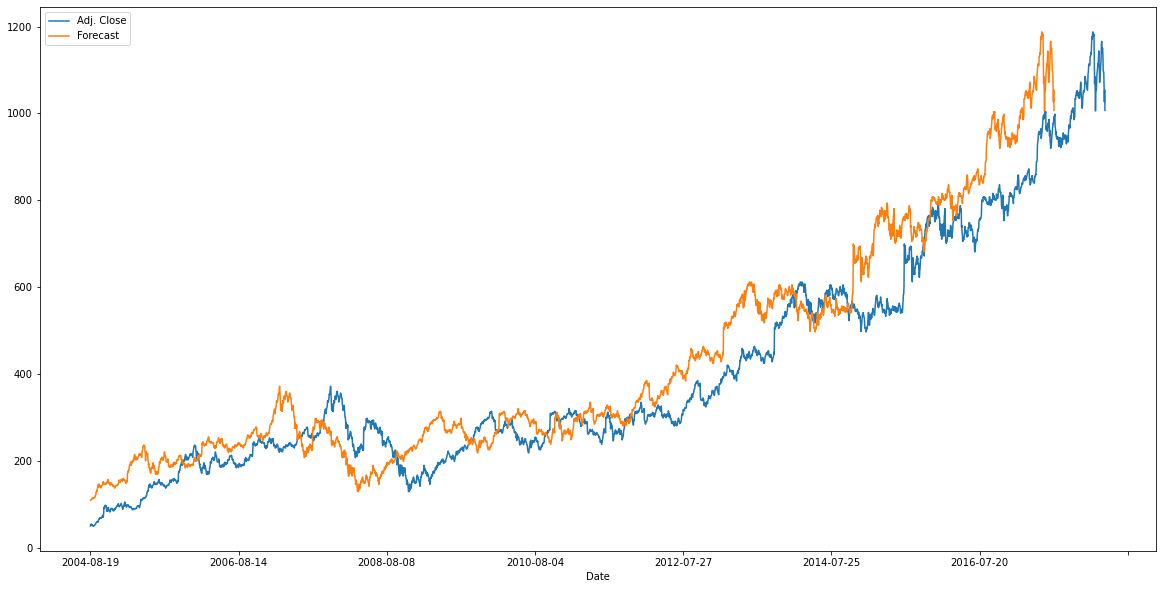

Figure 1.


In [20]:
# Define figure with measurement 20x5
plt.figure(figsize=(20,10))
# Plot adjusted close prices
stocks['Adj. Close'].plot()
# Plot forecasted prices
stocks['Forecast'].plot()
# Plot legend
plt.legend()
# Show plot
plt.show()

print('Figure 1.')

As stated, we want to plot all the adjusted close prices we know as one continuous data point, and then all the predicted values as one continuous data point <em>afterwards</em>.  These two data points will have no overlapping dates.  Let's therefore examine how many rows our dataframe has, and then examine the last row of our dataframe. 

In [21]:
# Get length of dataframe
print(stocks.shape)

# View last row of dataframe
display(stocks.tail(1))

print('\nFigure 2.')

(3424, 5)


,Adj. Close,Open-Close Percent Change,High-Low Percent Change,Adj. Volume,Forecast
Date,,,,,
2018-03-27,1006.94,-5.353887,6.707965,2940957.0,NaN



Figure 2.


Per Figure 2, we currently have 3,424 rows, and the index for the last row is the date 2018-03-27.

By using the .iloc[] method, we can save the index, or "name" of this data point, as a variable.

In [22]:
# Get data points for last record
print(stocks.iloc[-1])

# Save last index into variable
last_date_as_string = stocks.iloc[-1].name
print('\n',last_date_as_string)

Adj. Close                   1.006940e+03
Open-Close Percent Change   -5.353887e+00
High-Low Percent Change      6.707965e+00
Adj. Volume                  2.940957e+06
Forecast                              NaN
Name: 2018-03-27, dtype: float64

 2018-03-27


Now we want to add a new row to the dataframe, whose only value is our first forecasted price, and with an index of 2018-03-28.  Note that for this project, we will disregard the effect of weekends and holidays, and simply add the next day to the dataframe.  Then we will add another row, whose only value is the second predicted value, and with an index of 2018-03-29, and so on.

In [23]:
# Import datatime to work with time values
from datetime import datetime, timedelta

# Save the last_date as a date value
last_date = datetime.strptime(last_date_as_string,'%Y-%m-%d').date()

Recall that we are plotting all known adjusted close prices as one continuous data point, and all predicted values as one continuous datapoint.  We therefore need to clear out the forecast column, and only start filling it in with the predicted values starting on 2018-03-28.

In [24]:
# Preview stocks data
display(stocks.head())

# Fill Forecast column will NaN values
stocks['Forecast'] = np.nan

# Preview stocks data
display(stocks.head())

,Adj. Close,Open-Close Percent Change,High-Low Percent Change,Adj. Volume,Forecast
Date,,,,,
2004-08-19,50.322842,0.324968,8.441017,44659000.0,109.713676
2004-08-20,54.322689,7.227007,8.537313,22834300.0,110.230270
2004-08-23,54.869377,-1.227880,4.062357,18256100.0,110.064759
2004-08-24,52.597363,-5.726357,7.753210,15247300.0,110.340611
2004-08-25,53.164113,1.183658,3.966115,9188600.0,111.489156


,Adj. Close,Open-Close Percent Change,High-Low Percent Change,Adj. Volume,Forecast
Date,,,,,
2004-08-19,50.322842,0.324968,8.441017,44659000.0,NaN
2004-08-20,54.322689,7.227007,8.537313,22834300.0,NaN
2004-08-23,54.869377,-1.227880,4.062357,18256100.0,NaN
2004-08-24,52.597363,-5.726357,7.753210,15247300.0,NaN
2004-08-25,53.164113,1.183658,3.966115,9188600.0,NaN


At this point, we can add new rows for each day after 2018-03-27, with the predicted adjusted close price.  Adding new records with a defined index is as simple as "selecting" the record at that index, and defining the datapoints.  For example, observe what happens when we try to select the row with index 2018-03-28.

In [25]:
try:
    display(stocks.loc['2018-03-28'])
except:
    print('No such date exists.')

No such date exists.


As no such record exists, we get an error, but simply by defining data at this point, we can create the record.  We will only define the forecasted price.

In [26]:
# Define new datapoints with an index of 2018-03-28.
stocks.loc['2018-03-28'] = [np.nan, np.nan, np.nan, np.nan, 3]
display(stocks.loc['2018-03-28'] )
print('\nFigure 3.')

Adj. Close                   NaN
Open-Close Percent Change    NaN
High-Low Percent Change      NaN
Adj. Volume                  NaN
Forecast                     3.0
Name: 2018-03-28, dtype: float64


Figure 3.


Using this logic, we will now loop through our forecasted values and populate new points in our dataframe at future dates.  This loop will increment the "last date" by one day, then populate the data points.  Because last_date is still defined as the 2018-02-37, our first increment will change this to 2018-03-28, and replcace the hard-coded value in Figure 3 with the real prediciton, then proceed to populate the rest of the predictions.

In [27]:
# Loop for every predicted price in our x-day forecast (COME BACK AND DEFINE X)
for prediction in forecast:
    # Increment last_date by one day
    last_date += timedelta(days=1)
    
    # Where the index is the new "last date," populate only the Forecast column with the prediction
    stocks.loc[datetime.strftime(last_date, '%Y-%m-%d')] = [np.nan for _ in range(len(stocks.columns) -1)] + [prediction]

To illustrate the loop above, we will examine the head and tail of our dataframe.  Up until our last known adjusted close price, we have all data points except for the forecast, and after that point, the only data point we have is the forecast.  Also recall from from Figure 2 that we previously had 3,424 rows, and the last row had an index of the date 2018-03-27.  Observing the row count and last index in Figure 4, we now see a row count of 3,596, with a last index of the date 2018-09-15; we can also observe the place at which the datapoints populated changes.

In [28]:
# Get length of dataframe
print(stocks.shape)
# Preview start of dataframe
display(stocks.head())
# Preview point where known ends and predictions begin
display(stocks.head(-forecast_out+2))
# Preview end of dataframe
display(stocks.tail())

print('\nFigure 4.')

(3596, 5)


,Adj. Close,Open-Close Percent Change,High-Low Percent Change,Adj. Volume,Forecast
Date,,,,,
2004-08-19,50.322842,0.324968,8.441017,44659000.0,NaN
2004-08-20,54.322689,7.227007,8.537313,22834300.0,NaN
2004-08-23,54.869377,-1.227880,4.062357,18256100.0,NaN
2004-08-24,52.597363,-5.726357,7.753210,15247300.0,NaN
2004-08-25,53.164113,1.183658,3.966115,9188600.0,NaN


,Adj. Close,Open-Close Percent Change,High-Low Percent Change,Adj. Volume,Forecast
Date,,,,,
2004-08-19,50.322842,0.324968,8.441017,44659000.0,NaN
2004-08-20,54.322689,7.227007,8.537313,22834300.0,NaN
2004-08-23,54.869377,-1.227880,4.062357,18256100.0,NaN
2004-08-24,52.597363,-5.726357,7.753210,15247300.0,NaN
2004-08-25,53.164113,1.183658,3.966115,9188600.0,NaN
...,...,...,...,...,...
2018-03-23,1026.550000,-2.360729,4.089299,2413517.0,NaN
2018-03-26,1054.090000,0.332191,4.818025,3272409.0,NaN
2018-03-27,1006.940000,-5.353887,6.707965,2940957.0,NaN


,Adj. Close,Open-Close Percent Change,High-Low Percent Change,Adj. Volume,Forecast
Date,,,,,
2018-09-11,NaN,NaN,NaN,NaN,1221.355216
2018-09-12,NaN,NaN,NaN,NaN,1173.461744
2018-09-13,NaN,NaN,NaN,NaN,1143.470381
2018-09-14,NaN,NaN,NaN,NaN,1174.787562
2018-09-15,NaN,NaN,NaN,NaN,1117.828478



Figure 4.


Finally, we will simply plot both datapoints, Adjusted Close Prices, and Forecast, just as we did in Figure 1.  This time however, there will only be one point at each date, and the predicted prices will pick up where the known prices end.

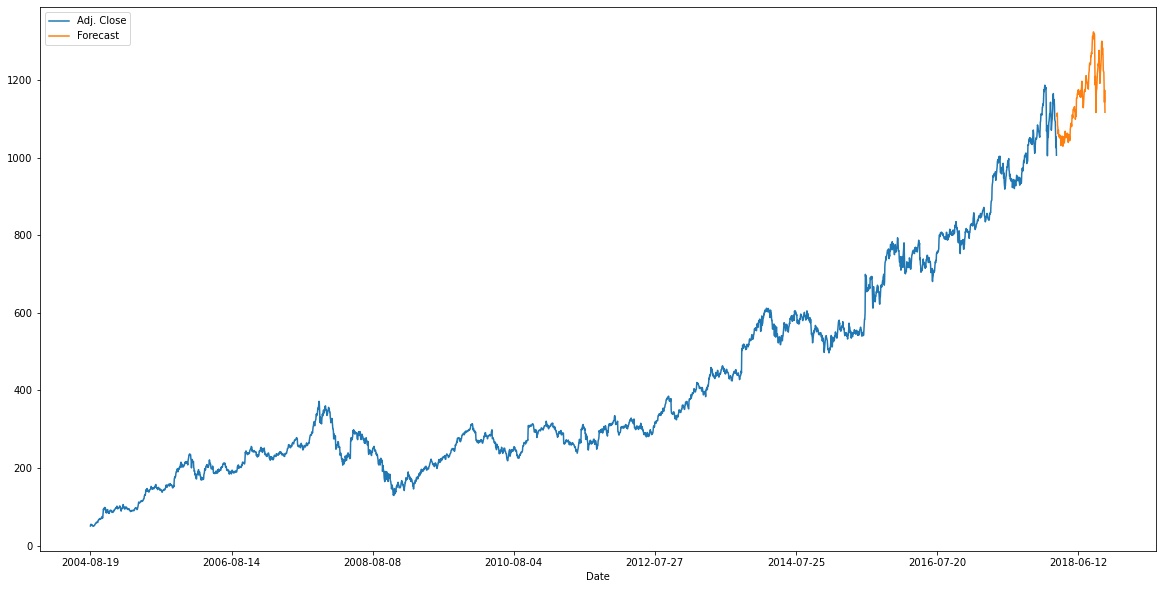

In [29]:
# Define figure with measurement 20x5
plt.figure(figsize=(20,10))
# Plot adjusted close prices
stocks['Adj. Close'].plot()
# Plot forecasted prices
stocks['Forecast'].plot()
# Show legend
plt.legend()
# Show plot
plt.show()

# Sources:
1. <a href="https://pythonprogramming.net/training-testing-machine-learning-tutorial/" target="_blank">Python Programming: Regression - Training and Testing</a>
2. <a href="https://pythonprogramming.net/forecasting-predicting-machine-learning-tutorial/" target="_blank">Python Programming: Regression - Forecasting and Predicting</a>